In [3]:
import json 
import time 
import sqlite3
conn = sqlite3.connect('t0data.sqlite')
cursor = conn.cursor()

In [16]:
if True:
    
    cursor.execute('DROP TABLE IF EXISTS files')
    cursor.execute('CREATE TABLE files (lfn TEXT, size INTEGER, timestamp INTEGER)')
    
    records = []
    payload = json.load(open('t0data.json'))['phedex']['dbs'][0]
    for d in payload['dataset']:
        for b in d['block']:
            for f in b['file']:
                lfn = f['lfn']
                timestamp = f['time_create']
                size = f['size'] / 1e9
                records.append((lfn, size, timestamp))
    cursor.executemany('INSERT INTO files VALUES (?,?,?)',records)
    conn.commit()

Loading data...


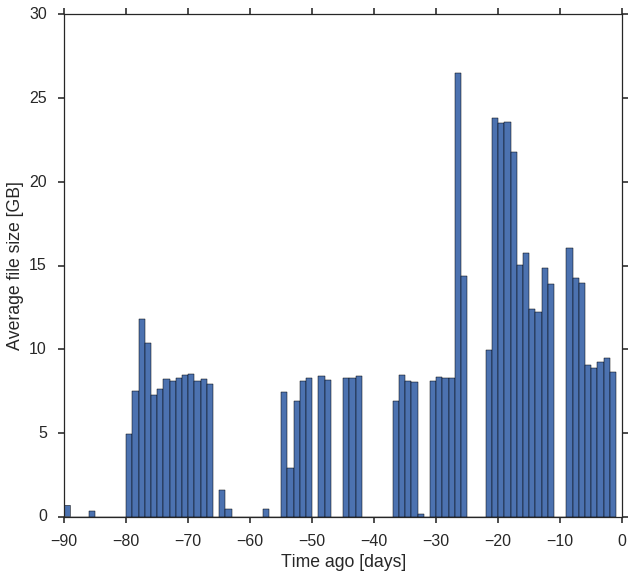

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn
import matplotlib as mpl
from scipy.stats import gaussian_kde
import re 

seaborn.set(style="ticks")
seaborn.set_context("poster")
mpl.rcParams['axes.linewidth'] = 1.25
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 9
plt.rcParams['figure.figsize'] = fig_size

x = []
y = []
regex = re.compile('.*RECO.*')
cmd = 'SELECT timestamp, size, lfn FROM files'
print 'Loading data...'
for data in cursor.execute(cmd):
    if not regex.match(data[2]):
        continue
    x.append(data[0])
    y.append(data[1])
now = time.time()
dates = (np.array(x) - now)/86400
sizes = np.array(y)

bins = np.arange(-30*3, 0, 1)
counts = np.histogram(dates, bins=bins)
volume = np.histogram(dates, bins=bins, weights=sizes)

plt.clf()
plt.hist(bins[:-1], bins=bins, 
         weights=np.nan_to_num(volume[0] / counts[0]))
plt.xlabel('Time ago [days]')
plt.ylabel('Average file size [GB]')
plt.show()